In [ ]:
pip install numpy matplotlib ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.3 MB/s eta 0:00:00



**Experiment 1 : Recreated CPP code**

Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%


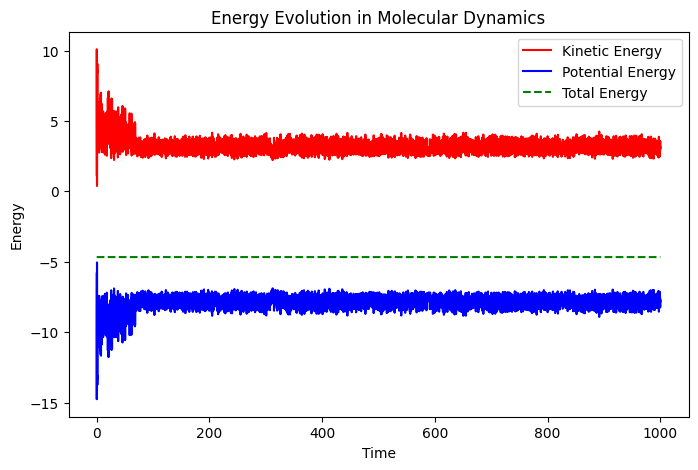

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class Vector3D:
    """3D vector operations for Molecular Dynamics Simulation"""
    def __init__(self, x=0.0, y=0.0, z=0.0):
        self.x, self.y, self.z = x, y, z

    def __add__(self, other):
        return Vector3D(self.x + other.x, self.y + other.y, self.z + other.z)

    def __sub__(self, other):
        return Vector3D(self.x - other.x, self.y - other.y, self.z - other.z)

    def __mul__(self, scalar):
        return Vector3D(self.x * scalar, self.y * scalar, self.z * scalar)

    def __truediv__(self, scalar):
        return Vector3D(self.x / scalar, self.y / scalar, self.z / scalar)

    def magnitude(self):
        return np.sqrt(self.x**2 + self.y**2 + self.z**2)

    def unit_vector(self):
        mag = self.magnitude()
        return self if mag == 0 else self / mag

    def to_numpy(self):
        return np.array([self.x, self.y, self.z])

class Particle:
    """Defines a particle with position, velocity, and force"""
    def __init__(self, particle_type=1, diameter=1.0, mass=1.0, position=None, velocity=None):
        self.type = particle_type
        self.diameter = diameter
        self.mass = mass
        self.position = position if position else Vector3D()
        self.velocity = velocity if velocity else Vector3D()
        self.force = Vector3D()
        self.pe = 0.0
        self.ke = 0.0

    def update_position(self, dt):
        self.position = self.position + self.velocity * dt

    def update_velocity(self, dt_half):
        self.velocity = self.velocity + (self.force * (dt_half / self.mass))

    def compute_kinetic_energy(self):
        self.ke = 0.5 * self.mass * self.velocity.magnitude()**2

def compute_potential_energy(particles, epsilon):
    """Computes Lennard-Jones potential energy of the system"""
    total_pe = 0
    for i, p1 in enumerate(particles):
        for j, p2 in enumerate(particles):
            if i >= j: continue  # Avoid double counting and self-interaction
            r_vec = p1.position - p2.position
            r = r_vec.magnitude()
            if r == 0: continue
            Uij = 4 * epsilon * ((p2.diameter / r)**12 - (p2.diameter / r)**6)
            total_pe += Uij
    return total_pe

def compute_forces(particles, epsilon):
    """Computes Lennard-Jones forces on each particle"""
    for p in particles:
        p.force = Vector3D(0, 0, 0)

    for i, p1 in enumerate(particles):
        for j, p2 in enumerate(particles):
            if i == j: continue
            r_vec = p1.position - p2.position
            r = r_vec.magnitude()
            if r == 0: continue
            force_magnitude = 48 * epsilon / r * ((p2.diameter / r)**12 - 0.5 * (p2.diameter / r)**6)
            force_ij = r_vec.unit_vector() * force_magnitude
            p1.force = p1.force + force_ij

def initialize_velocities(particles):
    """Initializes velocities with zero net motion"""
    for p in particles:
        p.velocity = Vector3D(np.random.uniform(-0.5, 0.5),
                              np.random.uniform(-0.5, 0.5),
                              np.random.uniform(-0.5, 0.5))

    avg_velocity = sum([p.velocity for p in particles], Vector3D()) / len(particles)
    for p in particles:
        p.velocity = p.velocity - avg_velocity

def velocity_verlet(particles, epsilon, dt, total_time, data_freq):
    """Velocity-Verlet Integration for Time Evolution"""
    steps = int(total_time / dt)
    energy_data = []

    for step in range(steps):
        for p in particles:
            p.update_velocity(dt / 2)

        for p in particles:
            p.update_position(dt)

        compute_forces(particles, epsilon)

        for p in particles:
            p.update_velocity(dt / 2)

        total_ke = sum([p.compute_kinetic_energy() or p.ke for p in particles])
        total_pe = compute_potential_energy(particles, epsilon)

        if step % data_freq == 0:
            energy_data.append((step * dt, total_ke, total_pe, total_ke + total_pe))

        if step % (steps // 10) == 0:
            print(f"Progress: {step / steps * 100:.1f}%")

    return energy_data

# --- Simulation Parameters ---
diameter = 1.0
mass = 1.0
lj_energy = 1.0
dt = 0.001
total_time = 1000
num_particles = 8
data_freq = 100

# --- Initialize Particles in a Cubic Lattice ---
particles = [
    Particle(1, diameter, mass, Vector3D(x, y, z))
    for x in range(2) for y in range(2) for z in range(2)
]

initialize_velocities(particles)
compute_forces(particles, lj_energy)

# --- Run Simulation ---
energy_data = velocity_verlet(particles, lj_energy, dt, total_time, data_freq)

# --- Plot Energy Evolution ---
times, ke, pe, total_energy = zip(*energy_data)

plt.figure(figsize=(8, 5))
plt.plot(times, ke, label="Kinetic Energy", color="r")
plt.plot(times, pe, label="Potential Energy", color="b")
plt.plot(times, total_energy, label="Total Energy", color="g", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.title("Energy Evolution in Molecular Dynamics")
plt.legend()
plt.show()


**Experiment 2 : Visualization of the trajectories and verification of the clumping action that could be seen after some timesteps**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, IntSlider

class Vector3D:
    """3D vector operations"""
    def __init__(self, x=0.0, y=0.0, z=0.0):
        self.x, self.y, self.z = x, y, z

    def __add__(self, other):
        return Vector3D(self.x + other.x, self.y + other.y, self.z + other.z)

    def __sub__(self, other):
        return Vector3D(self.x - other.x, self.y - other.y, self.z - other.z)

    def __mul__(self, scalar):
        return Vector3D(self.x * scalar, self.y * scalar, self.z * scalar)

    def __truediv__(self, scalar):
        return Vector3D(self.x / scalar, self.y / scalar, self.z / scalar)

    def magnitude(self):
        return np.sqrt(self.x**2 + self.y**2 + self.z**2)

    def unit_vector(self):
        mag = self.magnitude()
        return self if mag == 0 else self / mag

class Particle:
    """Defines a particle with position, velocity, and force"""
    def __init__(self, position, velocity):
        self.position = position
        self.velocity = velocity
        self.force = Vector3D(0, 0, 0)

    def update_position(self, dt):
        self.position = self.position + self.velocity * dt

    def update_velocity(self, dt_half, mass):
        self.velocity = self.velocity + (self.force * (dt_half / mass))

def compute_forces(particles, epsilon, sigma):
    """Computes Lennard-Jones forces"""
    for p in particles:
        p.force = Vector3D(0, 0, 0)

    for i, p1 in enumerate(particles):
        for j, p2 in enumerate(particles):
            if i == j: continue
            r_vec = p1.position - p2.position
            r = r_vec.magnitude()
            if r == 0: continue
            force_magnitude = 48 * epsilon / r * ((sigma / r)**12 - 0.5 * (sigma / r)**6)
            force_ij = r_vec.unit_vector() * force_magnitude
            p1.force = p1.force + force_ij

def velocity_verlet(particles, epsilon, sigma, dt, total_time):
    """Velocity-Verlet integration with full trajectory storage"""
    steps = int(total_time / dt)  # 500 steps expected
    positions = [[[] for _ in particles] for _ in range(steps)]  # Store all timesteps

    for step in range(steps):
        for i, p in enumerate(particles):
            p.update_velocity(dt / 2, mass=1.0)

        for i, p in enumerate(particles):
            p.update_position(dt)
            positions[step][i] = (p.position.x, p.position.y, p.position.z)  # Store every step

        compute_forces(particles, epsilon, sigma)

        for i, p in enumerate(particles):
            p.update_velocity(dt / 2, mass=1.0)

    return positions  # Contains full time evolution of each particle

# --- Simulation Parameters ---
sigma = 1.0  # Particle diameter
epsilon = 1.0  # Lennard-Jones potential strength
dt = 0.01
total_time = 500  # 500 time steps expected

# --- Initialize 8 Atoms in a 2x2x2 Lattice ---
particles = [
    Particle(Vector3D(x, y, z), Vector3D(np.random.uniform(-0.5, 0.5),
                                         np.random.uniform(-0.5, 0.5),
                                         np.random.uniform(-0.5, 0.5)))
    for x in range(2) for y in range(2) for z in range(2)
]

compute_forces(particles, epsilon, sigma)
positions = velocity_verlet(particles, epsilon, sigma, dt, total_time)

# --- Fix Slider Range ---
max_steps = len(positions) - 1  # Now should be 499 (0 to 499)

# --- Interactive 3D Trajectory Visualization with Spheres ---
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange']

def plot_trajectory(final_step):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    for i in range(len(particles)):
        x, y, z = zip(*[positions[step][i] for step in range(final_step)])

        ax.plot(x, y, z, color=colors[i], label=f"Atom {i+1}")

        # Plot sphere at the last selected timestep
        ax.scatter(x[-1], y[-1], z[-1], color=colors[i], s=100, edgecolors='black')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f"3D Trajectories of 8 Atoms (Final Step: {final_step})")
    ax.legend()
    plt.show()

# Interactive slider with correct range
interact(plot_trajectory, final_step=IntSlider(min=1, max=max_steps, step=1, value=max_steps//2));

interactive(children=(IntSlider(value=24999, description='final_step', max=49999, min=1), Output()), _dom_clas…

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, IntSlider

class Vector3D:
    """3D vector operations"""
    def __init__(self, x=0.0, y=0.0, z=0.0):
        self.x, self.y, self.z = x, y, z

    def __add__(self, other):
        return Vector3D(self.x + other.x, self.y + other.y, self.z + other.z)

    def __sub__(self, other):
        return Vector3D(self.x - other.x, self.y - other.y, self.z - other.z)

    def __mul__(self, scalar):
        return Vector3D(self.x * scalar, self.y * scalar, self.z * scalar)

    def __truediv__(self, scalar):
        return Vector3D(self.x / scalar, self.y / scalar, self.z / scalar)

    def magnitude(self):
        return np.sqrt(self.x**2 + self.y**2 + self.z**2)

    def unit_vector(self):
        mag = self.magnitude()
        return self if mag == 0 else self / mag

class Particle:
    """Defines a particle with position, velocity, and force"""
    def __init__(self, position, velocity):
        self.position = position
        self.velocity = velocity
        self.force = Vector3D(0, 0, 0)
        self.mass = 1.0  # Assume unit mass

    def kinetic_energy(self):
        return 0.5 * self.mass * self.velocity.magnitude() ** 2

    def update_position(self, dt):
        self.position = self.position + self.velocity * dt

    def update_velocity(self, dt_half):
        self.velocity = self.velocity + (self.force * dt_half)

def compute_forces_and_potential(particles, epsilon, sigma):
    """Computes Lennard-Jones forces and potential energy"""
    for p in particles:
        p.force = Vector3D(0, 0, 0)

    total_potential_energy = 0.0
    for i, p1 in enumerate(particles):
        for j, p2 in enumerate(particles):
            if i >= j: continue
            r_vec = p1.position - p2.position
            r = r_vec.magnitude()
            if r == 0: continue
            potential_energy = 4 * epsilon * ((sigma / r) ** 12 - (sigma / r) ** 6)
            total_potential_energy += potential_energy

            force_magnitude = 48 * epsilon / r * ((sigma / r) ** 12 - 0.5 * (sigma / r) ** 6)
            force_ij = r_vec.unit_vector() * force_magnitude
            p1.force = p1.force + force_ij
            p2.force = p2.force - force_ij  # Newton's Third Law

    return total_potential_energy

def velocity_verlet(particles, epsilon, sigma, dt, total_time):
    """Velocity-Verlet integration storing trajectory and energy data"""
    steps = int(total_time / dt)
    positions = [[[] for _ in particles] for _ in range(steps)]
    kinetic_energies = []
    potential_energies = []
    total_energies = []

    for step in range(steps):
        for p in particles:
            p.update_velocity(dt / 2)

        for p in particles:
            p.update_position(dt)

        potential_energy = compute_forces_and_potential(particles, epsilon, sigma)

        kinetic_energy = sum(p.kinetic_energy() for p in particles)
        total_energy = kinetic_energy + potential_energy

        kinetic_energies.append(kinetic_energy)
        potential_energies.append(potential_energy)
        total_energies.append(total_energy)

        for i, p in enumerate(particles):
            positions[step][i] = (p.position.x, p.position.y, p.position.z)

        for p in particles:
            p.update_velocity(dt / 2)

    return positions, kinetic_energies, potential_energies, total_energies

# --- Simulation Parameters ---
sigma = 1.0  # Particle diameter
epsilon = 1.0  # Lennard-Jones potential strength
dt = 0.01
total_time = 500  # 500 time steps expected

# --- Initialize 8 Atoms in a 2x2x2 Lattice ---
particles = [
    Particle(Vector3D(x, y, z), Vector3D(np.random.uniform(-0.5, 0.5),
                                         np.random.uniform(-0.5, 0.5),
                                         np.random.uniform(-0.5, 0.5)))
    for x in range(2) for y in range(2) for z in range(2)
]

positions, kinetic_energies, potential_energies, total_energies = velocity_verlet(
    particles, epsilon, sigma, dt, total_time
)

# --- Fix Slider Range ---
max_steps = len(positions) - 1  # Now should be 499 (0 to 499)

# --- Interactive 3D Trajectory and Energy Visualization ---
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange']

def plot_trajectory_and_energy(final_step):
    fig = plt.figure(figsize=(12, 6))

    # 3D Trajectory Plot
    ax1 = fig.add_subplot(121, projection='3d')

    for i in range(len(particles)):
        x, y, z = zip(*[positions[step][i] for step in range(final_step)])

        ax1.plot(x, y, z, color=colors[i], label=f"Atom {i+1}")

        # Plot sphere at the last selected timestep
        ax1.scatter(x[-1], y[-1], z[-1], color=colors[i], s=100, edgecolors='black')

    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title(f"3D Trajectories of 8 Atoms (Final Step: {final_step})")
    ax1.legend()

    # Energy Plot
    ax2 = fig.add_subplot(122)
    timesteps = np.arange(len(kinetic_energies))

    ax2.plot(timesteps[:final_step], kinetic_energies[:final_step], label="Kinetic Energy", color="r")
    ax2.plot(timesteps[:final_step], potential_energies[:final_step], label="Potential Energy", color="b")
    ax2.plot(timesteps[:final_step], total_energies[:final_step], label="Total Energy", color="g", linestyle="--")
    ax2.set_xlabel("Time Step")
    ax2.set_ylabel("Energy")
    ax2.set_title("Energy Evolution")
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Interactive slider with correct range
interact(plot_trajectory_and_energy, final_step=IntSlider(min=1, max=max_steps, step=1, value=max_steps//2));


interactive(children=(IntSlider(value=24999, description='final_step', max=49999, min=1), Output()), _dom_clas…

**Experiment 3 : Evolution of the force, velocity and position of each atom over a period of time**


--- First 10 Timesteps Data ---
Step 1:
Atom 1: Position=0.005, Velocity=0.544, Force=37.197
Atom 2: Position=0.998, Velocity=0.591, Force=37.197
Atom 3: Position=0.996, Velocity=0.523, Force=37.197
Atom 4: Position=1.414, Velocity=0.417, Force=37.197
Atom 5: Position=1.000, Velocity=0.228, Force=37.197
Atom 6: Position=1.415, Velocity=0.676, Force=37.197
Atom 7: Position=1.421, Velocity=0.702, Force=37.197
Atom 8: Position=1.737, Velocity=0.635, Force=37.197
--------------------------------------------------
Step 2:
Atom 1: Position=0.014, Velocity=0.894, Force=36.924
Atom 2: Position=0.997, Velocity=0.830, Force=36.628
Atom 3: Position=0.995, Velocity=0.177, Force=37.237
Atom 4: Position=1.417, Velocity=0.639, Force=35.952
Atom 5: Position=1.002, Velocity=0.199, Force=33.948
Atom 6: Position=1.420, Velocity=0.804, Force=36.087
Atom 7: Position=1.430, Velocity=1.038, Force=34.383
Atom 8: Position=1.745, Velocity=0.913, Force=33.863
--------------------------------------------------
S

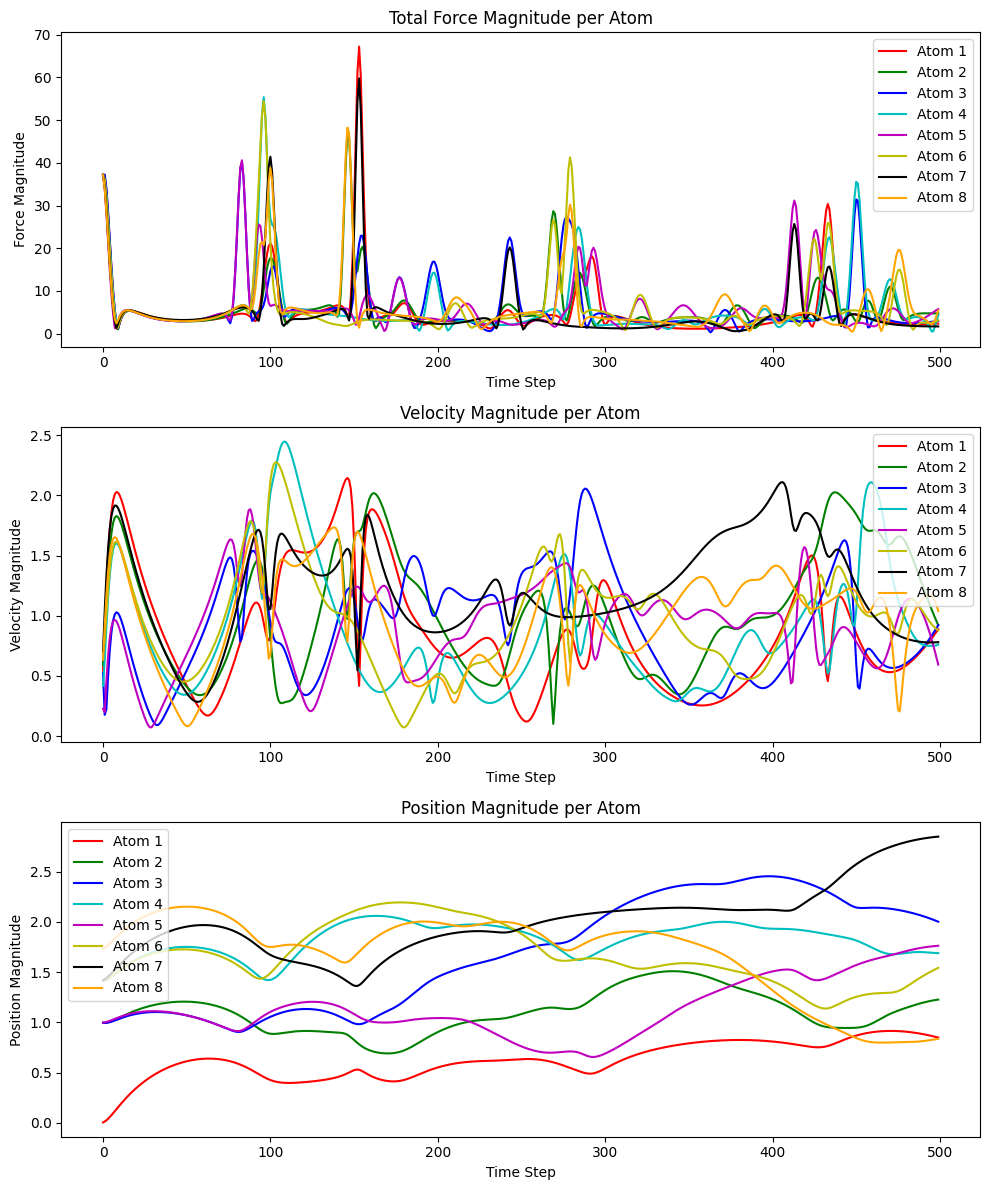

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

class Vector3D:
    """3D vector operations"""
    def __init__(self, x=0.0, y=0.0, z=0.0):
        self.x, self.y, self.z = x, y, z

    def __add__(self, other):
        return Vector3D(self.x + other.x, self.y + other.y, self.z + other.z)

    def __sub__(self, other):
        return Vector3D(self.x - other.x, self.y - other.y, self.z - other.z)

    def __mul__(self, scalar):
        return Vector3D(self.x * scalar, self.y * scalar, self.z * scalar)

    def __truediv__(self, scalar):
        return Vector3D(self.x / scalar, self.y / scalar, self.z / scalar)

    def magnitude(self):
        return np.sqrt(self.x**2 + self.y**2 + self.z**2)

    def unit_vector(self):
        mag = self.magnitude()
        if mag == 0:
            return Vector3D(0, 0, 0)  # Return a zero vector to prevent division by zero
        return Vector3D(self.x / mag, self.y / mag, self.z / mag)

class Particle:
    """Defines a particle with position, velocity, and force"""
    def __init__(self, position, velocity):
        self.position = position
        self.velocity = velocity
        self.force = Vector3D(0, 0, 0)

    def update_position(self, dt):
        self.position = self.position + self.velocity * dt

    def update_velocity(self, dt_half, mass):
        self.velocity = self.velocity + (self.force * (dt_half / mass))

def compute_forces(particles, epsilon, sigma):
    """Computes Lennard-Jones forces"""
    for p in particles:
        p.force = Vector3D(0, 0, 0)

    for i, p1 in enumerate(particles):
        for j, p2 in enumerate(particles):
            if i == j: continue
            r_vec = p1.position - p2.position
            r = r_vec.magnitude()
            if r == 0: continue
            force_magnitude = 48 * epsilon / r * ((sigma / r)**12 - 0.5 * (sigma / r)**6)
            force_ij = r_vec.unit_vector() * force_magnitude
            p1.force = p1.force + force_ij

def velocity_verlet(particles, epsilon, sigma, dt, total_time):
    """Velocity-Verlet integration with full trajectory storage"""
    steps = int(total_time / dt)

    positions = [[[] for _ in particles] for _ in range(steps)]
    velocities = [[[] for _ in particles] for _ in range(steps)]
    forces = [[[] for _ in particles] for _ in range(steps)]

    for step in range(steps):
        for i, p in enumerate(particles):
            p.update_velocity(dt / 2, mass=1.0)

        for i, p in enumerate(particles):
            p.update_position(dt)

            positions[step][i] = p.position.magnitude()
            velocities[step][i] = p.velocity.magnitude()
            forces[step][i] = p.force.magnitude()

        compute_forces(particles, epsilon, sigma)

        for i, p in enumerate(particles):
            p.update_velocity(dt / 2, mass=1.0)

    return positions, velocities, forces  # Full time evolution

# --- Simulation Parameters ---
sigma = 1.0  # Particle diameter
epsilon = 1.0  # Lennard-Jones potential strength
dt = 0.01
total_time = 5  # Expecting 500 steps

# --- Initialize 8 Atoms in a 2x2x2 Lattice ---
particles = [
    Particle(Vector3D(x, y, z), Vector3D(np.random.uniform(-0.5, 0.5),
                                         np.random.uniform(-0.5, 0.5),
                                         np.random.uniform(-0.5, 0.5)))
    for x in range(2) for y in range(2) for z in range(2)
]

compute_forces(particles, epsilon, sigma)
positions, velocities, forces = velocity_verlet(particles, epsilon, sigma, dt, total_time)

# --- Print Data for First 10 Timesteps ---
print("\n--- First 10 Timesteps Data ---")
for step in range(10):
    print(f"Step {step+1}:")
    for i in range(8):
        print(f"Atom {i+1}: Position={positions[step][i]:.3f}, Velocity={velocities[step][i]:.3f}, Force={forces[step][i]:.3f}")
    print("-" * 50)

# --- Plotting Force, Velocity, and Position Magnitudes over Time ---
timesteps = np.arange(len(positions))  # X-axis (500 points)

colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange']

fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# Force Magnitudes
for i in range(8):
    axs[0].plot(timesteps, [forces[step][i] for step in range(len(positions))], color=colors[i], label=f"Atom {i+1}")
axs[0].set_title("Total Force Magnitude per Atom")
axs[0].set_xlabel("Time Step")
axs[0].set_ylabel("Force Magnitude")
axs[0].legend()

# Velocity Magnitudes
for i in range(8):
    axs[1].plot(timesteps, [velocities[step][i] for step in range(len(positions))], color=colors[i], label=f"Atom {i+1}")
axs[1].set_title("Velocity Magnitude per Atom")
axs[1].set_xlabel("Time Step")
axs[1].set_ylabel("Velocity Magnitude")
axs[1].legend()

# Position Magnitudes
for i in range(8):
    axs[2].plot(timesteps, [positions[step][i] for step in range(len(positions))], color=colors[i], label=f"Atom {i+1}")
axs[2].set_title("Position Magnitude per Atom")
axs[2].set_xlabel("Time Step")
axs[2].set_ylabel("Position Magnitude")
axs[2].legend()

plt.tight_layout()
plt.show()

**Experiment 4: The ratio of force, velocity and position due to pairwise interaction as compared to complete interaction:**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

class Vector3D:
    """3D vector operations"""
    def __init__(self, x=0.0, y=0.0, z=0.0):
        self.x, self.y, self.z = x, y, z

    def __add__(self, other):
        return Vector3D(self.x + other.x, self.y + other.y, self.z + other.z)

    def __sub__(self, other):
        return Vector3D(self.x - other.x, self.y - other.y, self.z - other.z)

    def __mul__(self, scalar):
        return Vector3D(self.x * scalar, self.y * scalar, self.z * scalar)

    def __truediv__(self, scalar):
        return Vector3D(self.x / scalar, self.y / scalar, self.z / scalar)

    def magnitude(self):
        return np.sqrt(self.x**2 + self.y**2 + self.z**2)

    def unit_vector(self):
        mag = self.magnitude()
        if mag == 0:
            return Vector3D(0, 0, 0)
        return self / mag

class Particle:
    """Defines a particle with position, velocity, and force"""
    def __init__(self, position, velocity):
        self.position = position
        self.velocity = velocity
        self.force = Vector3D(0, 0, 0)

    def update_position(self, dt):
        self.position = self.position + self.velocity * dt

    def update_velocity(self, dt_half, mass):
        self.velocity = self.velocity + (self.force * (dt_half / mass))

def compute_forces(particles, epsilon, sigma):
    """Computes Lennard-Jones forces"""
    forces_matrix = np.zeros((len(particles), len(particles)), dtype=object)

    for i, p1 in enumerate(particles):
        p1.force = Vector3D(0, 0, 0)  # Reset total force
        for j, p2 in enumerate(particles):
            if i == j:
                continue  # Skip self-interaction

            r_vec = p1.position - p2.position
            r = r_vec.magnitude()
            if r == 0:
                continue  # Prevent division by zero

            force_magnitude = 48 * epsilon / r * ((sigma / r)**12 - 0.5 * (sigma / r)**6)
            force_ij = r_vec.unit_vector() * force_magnitude  # Force by j on i

            p1.force = p1.force + force_ij  # Accumulate total force on p1
            forces_matrix[i][j] = force_ij  # Store pairwise force

    return forces_matrix  # Return pairwise forces

def velocity_verlet(particles, epsilon, sigma, dt, total_time):
    """Velocity-Verlet integration storing all necessary values"""
    steps = int(total_time / dt)

    positions = [[[] for _ in particles] for _ in range(steps)]
    velocities = [[[] for _ in particles] for _ in range(steps)]
    forces = [[[] for _ in particles] for _ in range(steps)]
    pairwise_forces_history = []

    for step in range(steps):
        for i, p in enumerate(particles):
            p.update_velocity(dt / 2, mass=1.0)

        for i, p in enumerate(particles):
            p.update_position(dt)

            positions[step][i] = p.position.magnitude()
            velocities[step][i] = p.velocity.magnitude()
            forces[step][i] = p.force.magnitude()

        pairwise_forces = compute_forces(particles, epsilon, sigma)
        pairwise_forces_history.append(pairwise_forces)

        for i, p in enumerate(particles):
            p.update_velocity(dt / 2, mass=1.0)

    return positions, velocities, forces, pairwise_forces_history  # Include pairwise forces

# --- Simulation Parameters ---
sigma = 1.0  # Particle diameter
epsilon = 1.0  # Lennard-Jones potential strength
dt = 0.01
total_time = 5  # Expecting 500 steps

# --- Initialize 8 Atoms in a 2x2x2 Lattice ---
particles = [
    Particle(Vector3D(x, y, z), Vector3D(np.random.uniform(-0.5, 0.5),
                                         np.random.uniform(-0.5, 0.5),
                                         np.random.uniform(-0.5, 0.5)))
    for x in range(2) for y in range(2) for z in range(2)
]

positions, velocities, forces, pairwise_forces_history = velocity_verlet(particles, epsilon, sigma, dt, total_time)

# --- Select Two Arbitrary Atoms ---
atom_A = 0
atom_B = 3  # Arbitrary indices of two atoms

print("\n--- Pairwise Force Analysis Between Atom A and Atom B ---")
for step in range(10):  # Show first 10 steps for clarity
    pairwise_force_AB = pairwise_forces_history[step][atom_A][atom_B].magnitude()
    total_force_A = forces[step][atom_A]
    total_force_B = forces[step][atom_B]

    velocity_change_due_to_AB = pairwise_force_AB * dt / 1.0  # Assuming mass = 1.0
    total_velocity_change_A = total_force_A * dt / 1.0
    total_velocity_change_B = total_force_B * dt / 1.0

    position_change_due_to_AB = velocity_change_due_to_AB * dt
    total_position_change_A = total_velocity_change_A * dt
    total_position_change_B = total_velocity_change_B * dt

    print(f"Step {step+1}:")
    print(f"Pairwise Force (A←B): {pairwise_force_AB:.5f}, Ratio to Total Force (A): {pairwise_force_AB / total_force_A:.5f}")
    print(f"Velocity Change Due to A←B: {velocity_change_due_to_AB:.5f}, Ratio to Total Velocity Change (A): {velocity_change_due_to_AB / total_velocity_change_A:.5f}")
    print(f"Position Change Due to A←B: {position_change_due_to_AB:.5f}, Ratio to Total Position Change (A): {position_change_due_to_AB / total_position_change_A:.5f}")
    print("-" * 50)



--- Pairwise Force Analysis Between Atom A and Atom B ---
Step 1:
Pairwise Force (A←B): 1.58846, Ratio to Total Force (A): inf
Velocity Change Due to A←B: 0.01588, Ratio to Total Velocity Change (A): inf
Position Change Due to A←B: 0.00016, Ratio to Total Position Change (A): inf
--------------------------------------------------
Step 2:
Pairwise Force (A←B): 1.55165, Ratio to Total Force (A): 0.03901
Velocity Change Due to A←B: 0.01552, Ratio to Total Velocity Change (A): 0.03901
Position Change Due to A←B: 0.00016, Ratio to Total Position Change (A): 0.03901
--------------------------------------------------
Step 3:
Pairwise Force (A←B): 1.48456, Ratio to Total Force (A): 0.03757
Velocity Change Due to A←B: 0.01485, Ratio to Total Velocity Change (A): 0.03757
Position Change Due to A←B: 0.00015, Ratio to Total Position Change (A): 0.03757
--------------------------------------------------
Step 4:
Pairwise Force (A←B): 1.39443, Ratio to Total Force (A): 0.03867
Velocity Change Due to

<ipython-input-6-048a46bd550b>:130: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"Pairwise Force (A←B): {pairwise_force_AB:.5f}, Ratio to Total Force (A): {pairwise_force_AB / total_force_A:.5f}")
<ipython-input-6-048a46bd550b>:131: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"Velocity Change Due to A←B: {velocity_change_due_to_AB:.5f}, Ratio to Total Velocity Change (A): {velocity_change_due_to_AB / total_velocity_change_A:.5f}")
<ipython-input-6-048a46bd550b>:132: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"Position Change Due to A←B: {position_change_due_to_AB:.5f}, Ratio to Total Position Change (A): {position_change_due_to_AB / total_position_change_A:.5f}")


**Experiment 5 : Di-atom model**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, IntSlider

class Vector3D:
    """3D vector operations"""
    def __init__(self, x=0.0, y=0.0, z=0.0):
        self.x, self.y, self.z = x, y, z

    def __add__(self, other):
        return Vector3D(self.x + other.x, self.y + other.y, self.z + other.z)

    def __sub__(self, other):
        return Vector3D(self.x - other.x, self.y - other.y, self.z - other.z)

    def __mul__(self, scalar):
        return Vector3D(self.x * scalar, self.y * scalar, self.z * scalar)

    def __truediv__(self, scalar):
        return Vector3D(self.x / scalar, self.y / scalar, self.z / scalar)

    def magnitude(self):
        return np.sqrt(self.x**2 + self.y**2 + self.z**2)

    def unit_vector(self):
        mag = self.magnitude()
        return self if mag == 0 else self / mag

class Particle:
    """Defines a particle with position, velocity, and force"""
    def __init__(self, position, velocity):
        self.position = position
        self.velocity = velocity
        self.force = Vector3D(0, 0, 0)
        self.mass = 1.0  # Assume unit mass

    def kinetic_energy(self):
        return 0.5 * self.mass * self.velocity.magnitude() ** 2

    def update_position(self, dt):
        self.position = self.position + self.velocity * dt

    def update_velocity(self, dt_half):
        self.velocity = self.velocity + (self.force * (dt_half / self.mass))

def compute_forces_and_potential(particles, epsilon, sigma):
    """Computes Lennard-Jones forces and potential energy"""
    p1, p2 = particles[0], particles[1]

    # Reset forces
    p1.force, p2.force = Vector3D(0, 0, 0), Vector3D(0, 0, 0)

    # Compute distance vector and magnitude
    r_vec = p1.position - p2.position
    r = r_vec.magnitude()
    if r == 0:
        return 0  # Prevent division by zero

    # Compute Lennard-Jones potential energy
    potential_energy = 4 * epsilon * ((sigma / r) ** 12 - (sigma / r) ** 6)

    # Compute Lennard-Jones force
    force_magnitude = 48 * epsilon / r * ((sigma / r) ** 12 - 0.5 * (sigma / r) ** 6)
    force_ij = r_vec.unit_vector() * force_magnitude  # Force on p1 due to p2

    # Apply Newton’s Third Law: Equal and opposite force
    p1.force = p1.force + force_ij
    p2.force = p2.force - force_ij  # Negative for opposite direction

    return potential_energy

def velocity_verlet(particles, epsilon, sigma, dt, total_time):
    """Velocity-Verlet integration storing all trajectory & energy data"""
    steps = int(total_time / dt)
    positions = [[[], []] for _ in range(steps)]  # Store all timesteps
    kinetic_energies = []
    potential_energies = []
    total_energies = []

    for step in range(steps):
        for p in particles:
            p.update_velocity(dt / 2)

        for p in particles:
            p.update_position(dt)

        potential_energy = compute_forces_and_potential(particles, epsilon, sigma)

        kinetic_energy = sum(p.kinetic_energy() for p in particles)
        total_energy = kinetic_energy + potential_energy

        kinetic_energies.append(kinetic_energy)
        potential_energies.append(potential_energy)
        total_energies.append(total_energy)

        for i, p in enumerate(particles):
            positions[step][i] = (p.position.x, p.position.y, p.position.z)  # Store every step

        for p in particles:
            p.update_velocity(dt / 2)

    return positions, kinetic_energies, potential_energies, total_energies

# --- Simulation Parameters ---
sigma = 1.0  # Particle diameter
epsilon = 1.0  # Lennard-Jones potential strength
dt = 0.01
total_time = 1  # 500 time steps expected

# --- Initialize Two Atoms ---
particles = [
    Particle(Vector3D(0, 0, 0), Vector3D(np.random.uniform(-0.5, 0.5),
                                         np.random.uniform(-0.5, 0.5),
                                         np.random.uniform(-0.5, 0.5))),
    Particle(Vector3D(1, 0, 0), Vector3D(np.random.uniform(-0.5, 0.5),
                                         np.random.uniform(-0.5, 0.5),
                                         np.random.uniform(-0.5, 0.5)))
]

positions, kinetic_energies, potential_energies, total_energies = velocity_verlet(particles, epsilon, sigma, dt, total_time)

# --- Fix Slider Range ---
max_steps = len(positions) - 1  # Now should be 499 (0 to 499)

# --- Energy + Trajectory Plot ---
colors = ['r', 'b']  # Two atoms, two colors

def plot_trajectory_and_energy(final_step):
    fig = plt.figure(figsize=(12, 6))

    # 3D Trajectory Plot
    ax1 = fig.add_subplot(121, projection='3d')

    for i in range(2):  # Only two atoms
        x, y, z = zip(*[positions[step][i] for step in range(final_step)])

        ax1.plot(x, y, z, color=colors[i], label=f"Atom {i+1}")

        # Plot the last selected timestep as a sphere
        ax1.scatter(x[-1], y[-1], z[-1], color=colors[i], s=100, edgecolors='black')

    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title(f"3D Trajectories of Two Atoms (Final Step: {final_step})")
    ax1.legend()

    # Energy Plot
    ax2 = fig.add_subplot(122)
    timesteps = np.arange(len(kinetic_energies))

    ax2.plot(timesteps[:final_step], kinetic_energies[:final_step], label="Kinetic Energy", color="r")
    ax2.plot(timesteps[:final_step], potential_energies[:final_step], label="Potential Energy", color="b")
    ax2.plot(timesteps[:final_step], total_energies[:final_step], label="Total Energy", color="g", linestyle="--")
    ax2.set_xlabel("Time Step")
    ax2.set_ylabel("Energy")
    ax2.set_title("Energy Evolution")
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Interactive slider with correct range
interact(plot_trajectory_and_energy, final_step=IntSlider(min=1, max=max_steps, step=1, value=max_steps//2));


interactive(children=(IntSlider(value=49, description='final_step', max=99, min=1), Output()), _dom_classes=('…

#  Unit analysis -

**Fixed quantities** -
Length is fixed as
σ
σ
In our case, we assume
σ
=
3.4
σ=3.4 Å (Angstrom) for argon
This sets the scale for all distances in the simulation.

Energy is fixed as
ϵ
This is typically the depth of the Lennard-Jones potential well.
For argon,
ϵ
=
1.65
×
10
−
21
ϵ=1.65×10
−21
  J.
This sets the scale for all energy calculations.

Mass is fixed as
m
This is typically the mass of one simulated atom or molecule.
For argon,
m
=
6.63
×
10
−
26
m=6.63×10
−26
  kg.
This sets the scale for momentum and kinetic energy.


**Derived quantities** -

Time τ

Velocity v

Force F

Temperature T

**Experiment 6 : Adding Periodic boundary condition to the two atom model**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, IntSlider

class Vector3D:
    """3D vector operations with periodic boundary conditions"""
    def __init__(self, x=0.0, y=0.0, z=0.0):
        self.x, self.y, self.z = x, y, z

    def __add__(self, other):
        return Vector3D(self.x + other.x, self.y + other.y, self.z + other.z)

    def __sub__(self, other):
        return Vector3D(self.x - other.x, self.y - other.y, self.z - other.z)

    def __mul__(self, scalar):
        return Vector3D(self.x * scalar, self.y * scalar, self.z * scalar)

    def __truediv__(self, scalar):
        return Vector3D(self.x / scalar, self.y / scalar, self.z / scalar)

    def magnitude(self):
        return np.sqrt(self.x**2 + self.y**2 + self.z**2)

    def unit_vector(self):
        mag = self.magnitude()
        return self if mag == 0 else self / mag

    def apply_pbc(self, box_size):
        """Applies periodic boundary conditions (PBC)"""
        self.x = (self.x + box_size) % box_size
        self.y = (self.y + box_size) % box_size
        self.z = (self.z + box_size) % box_size

    @staticmethod
    def minimum_image(r, box_size):
        """Applies minimum image convention for distance calculations"""
        return Vector3D(
            r.x - box_size * round(r.x / box_size),
            r.y - box_size * round(r.y / box_size),
            r.z - box_size * round(r.z / box_size)
        )

class Particle:
    """Defines a particle with position, velocity, and force"""
    def __init__(self, position, velocity):
        self.position = position
        self.velocity = velocity
        self.force = Vector3D(0, 0, 0)
        self.mass = 1.0  # Assume unit mass

    def kinetic_energy(self):
        return 0.5 * self.mass * self.velocity.magnitude() ** 2

    def update_position(self, dt, box_size):
        self.position = self.position + self.velocity * dt
        self.position.apply_pbc(box_size)  # Enforce periodic boundary conditions

    def update_velocity(self, dt_half):
        self.velocity = self.velocity + (self.force * (dt_half / self.mass))

def compute_forces_and_potential(particles, epsilon, sigma, box_size):
    """Computes Lennard-Jones forces and potential energy with PBC"""
    p1, p2 = particles[0], particles[1]

    # Reset forces
    p1.force, p2.force = Vector3D(0, 0, 0), Vector3D(0, 0, 0)

    # Compute distance vector using the minimum image convention
    r_vec = Vector3D.minimum_image(p1.position - p2.position, box_size)
    r = r_vec.magnitude()
    if r == 0:
        return 0  # Prevent division by zero

    # Compute Lennard-Jones potential energy
    potential_energy = 4 * epsilon * ((sigma / r) ** 12 - (sigma / r) ** 6)

    # Compute Lennard-Jones force
    force_magnitude = 48 * epsilon / r * ((sigma / r) ** 12 - 0.5 * (sigma / r) ** 6)
    force_ij = r_vec.unit_vector() * force_magnitude  # Force on p1 due to p2

    # Apply Newton’s Third Law: Equal and opposite force
    p1.force = p1.force + force_ij
    p2.force = p2.force - force_ij  # Negative for opposite direction

    return potential_energy

def velocity_verlet(particles, epsilon, sigma, dt, total_time, box_size):
    """Velocity-Verlet integration storing all trajectory & energy data"""
    steps = int(total_time / dt)
    positions = [[[], []] for _ in range(steps)]  # Store all timesteps
    kinetic_energies = []
    potential_energies = []
    total_energies = []

    for step in range(steps):
        for p in particles:
            p.update_velocity(dt / 2)

        for p in particles:
            p.update_position(dt, box_size)  # Apply PBC when updating position

        potential_energy = compute_forces_and_potential(particles, epsilon, sigma, box_size)

        kinetic_energy = sum(p.kinetic_energy() for p in particles)
        total_energy = kinetic_energy + potential_energy

        kinetic_energies.append(kinetic_energy)
        potential_energies.append(potential_energy)
        total_energies.append(total_energy)

        for i, p in enumerate(particles):
            positions[step][i] = (p.position.x, p.position.y, p.position.z)  # Store every step

        for p in particles:
            p.update_velocity(dt / 2)

    return positions, kinetic_energies, potential_energies, total_energies

# --- Simulation Parameters ---
sigma = 1.0  # Particle diameter
epsilon = 1.0  # Lennard-Jones potential strength
dt = 0.01
total_time = 500  # 500 time steps expected
box_size = 10.0 * sigma  # Simulation box size = 10 * sigma

# --- Initialize Two Atoms ---
particles = [
    Particle(Vector3D(0, 0, 0), Vector3D(np.random.uniform(-0.5, 0.5),
                                         np.random.uniform(-0.5, 0.5),
                                         np.random.uniform(-0.5, 0.5))),
    Particle(Vector3D(9.0, 0, 0), Vector3D(np.random.uniform(-0.5, 0.5),
                                           np.random.uniform(-0.5, 0.5),
                                           np.random.uniform(-0.5, 0.5)))
]

positions, kinetic_energies, potential_energies, total_energies = velocity_verlet(
    particles, epsilon, sigma, dt, total_time, box_size
)

# --- Interactive 3D Trajectory and Energy Visualization ---
colors = ['r', 'b']

def plot_trajectory_and_energy(final_step):
    fig = plt.figure(figsize=(12, 6))

    # 3D Trajectory Plot
    ax1 = fig.add_subplot(121, projection='3d')

    for i in range(2):  # Only two atoms
        x, y, z = zip(*[positions[step][i] for step in range(final_step)])

        ax1.plot(x, y, z, color=colors[i], label=f"Atom {i+1}")

        # Plot the last selected timestep as a sphere
        ax1.scatter(x[-1], y[-1], z[-1], color=colors[i], s=100, edgecolors='black')

    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title(f"3D Trajectories of Two Atoms (Final Step: {final_step}) with PBC")
    ax1.legend()

    # Energy Plot
    ax2 = fig.add_subplot(122)
    timesteps = np.arange(len(kinetic_energies))

    ax2.plot(timesteps[:final_step], kinetic_energies[:final_step], label="Kinetic Energy", color="r")
    ax2.plot(timesteps[:final_step], potential_energies[:final_step], label="Potential Energy", color="b")
    ax2.plot(timesteps[:final_step], total_energies[:final_step], label="Total Energy", color="g", linestyle="--")
    ax2.set_xlabel("Time Step")
    ax2.set_ylabel("Energy")
    ax2.set_title("Energy Evolution")
    ax2.legend()

    plt.tight_layout()
    plt.show()

interact(plot_trajectory_and_energy, final_step=IntSlider(min=1, max=len(positions)-1, step=1, value=(len(positions)-1)//2));


interactive(children=(IntSlider(value=24999, description='final_step', max=49999, min=1), Output()), _dom_clas…

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from ipywidgets import interact, IntSlider

class Vector3D:
    """3D vector operations with periodic boundary conditions"""
    def __init__(self, x=0.0, y=0.0, z=0.0):
        self.x, self.y, self.z = x, y, z

    def __add__(self, other):
        return Vector3D(self.x + other.x, self.y + other.y, self.z + other.z)

    def __sub__(self, other):
        return Vector3D(self.x - other.x, self.y - other.y, self.z - other.z)

    def __mul__(self, scalar):
        return Vector3D(self.x * scalar, self.y * scalar, self.z * scalar)

    def __truediv__(self, scalar):
        return Vector3D(self.x / scalar, self.y / scalar, self.z / scalar)

    def magnitude(self):
        return np.sqrt(self.x**2 + self.y**2 + self.z**2)

    def unit_vector(self):
        mag = self.magnitude()
        return self if mag == 0 else self / mag

    def apply_pbc(self, box_size):
        """Applies periodic boundary conditions (PBC)"""
        self.x = (self.x + box_size) % box_size
        self.y = (self.y + box_size) % box_size
        self.z = (self.z + box_size) % box_size

    @staticmethod
    def minimum_image(r, box_size):
        """Applies minimum image convention for distance calculations"""
        return Vector3D(
            r.x - box_size * round(r.x / box_size),
            r.y - box_size * round(r.y / box_size),
            r.z - box_size * round(r.z / box_size)
        )

class Particle:
    """Defines a particle with position, velocity, and force"""
    def __init__(self, position, velocity):
        self.position = position
        self.velocity = velocity
        self.force = Vector3D(0, 0, 0)
        self.mass = 1.0  # Assume unit mass

    def kinetic_energy(self):
        return 0.5 * self.mass * self.velocity.magnitude() ** 2

    def update_position(self, dt, box_size):
        self.position = self.position + self.velocity * dt
        self.position.apply_pbc(box_size)  # Enforce periodic boundary conditions

    def update_velocity(self, dt_half):
        self.velocity = self.velocity + (self.force * (dt_half / self.mass))

def compute_forces_and_potential(particles, epsilon, sigma, box_size):
    """Computes Lennard-Jones forces and potential energy with PBC"""
    p1, p2 = particles[0], particles[1]

    # Reset forces
    p1.force, p2.force = Vector3D(0, 0, 0), Vector3D(0, 0, 0)

    # Compute distance vector using the minimum image convention
    r_vec = Vector3D.minimum_image(p1.position - p2.position, box_size)
    r = r_vec.magnitude()
    if r == 0:
        return 0  # Prevent division by zero

    # Compute Lennard-Jones potential energy
    potential_energy = 4 * epsilon * ((sigma / r) ** 12 - (sigma / r) ** 6)

    # Compute Lennard-Jones force
    force_magnitude = 48 * epsilon / r * ((sigma / r) ** 12 - 0.5 * (sigma / r) ** 6)
    force_ij = r_vec.unit_vector() * force_magnitude  # Force on p1 due to p2

    # Apply Newton’s Third Law: Equal and opposite force
    p1.force = p1.force + force_ij
    p2.force = p2.force - force_ij  # Negative for opposite direction

    return potential_energy

def velocity_verlet(particles, epsilon, sigma, dt, total_time, box_size):
    """Velocity-Verlet integration storing all trajectory & energy data"""
    steps = int(total_time / dt)
    positions = [[[], []] for _ in range(steps)]  # Store all timesteps
    kinetic_energies = []
    potential_energies = []
    total_energies = []

    for step in range(steps):
        for p in particles:
            p.update_velocity(dt / 2)

        for p in particles:
            p.update_position(dt, box_size)  # Apply PBC when updating position

        potential_energy = compute_forces_and_potential(particles, epsilon, sigma, box_size)

        kinetic_energy = sum(p.kinetic_energy() for p in particles)
        total_energy = kinetic_energy + potential_energy

        kinetic_energies.append(kinetic_energy)
        potential_energies.append(potential_energy)
        total_energies.append(total_energy)

        for i, p in enumerate(particles):
            positions[step][i] = (p.position.x, p.position.y, p.position.z)  # Store every step

        for p in particles:
            p.update_velocity(dt / 2)

    return positions, kinetic_energies, potential_energies, total_energies

def plot_sphere(ax, center, radius=0.5, color='r'):
    """Plots a 3D sphere at the given center with a specified radius."""
    u = np.linspace(0, 2 * np.pi, 20)
    v = np.linspace(0, np.pi, 20)

    x = center[0] + radius * np.outer(np.cos(u), np.sin(v))
    y = center[1] + radius * np.outer(np.sin(u), np.sin(v))
    z = center[2] + radius * np.outer(np.ones(np.size(u)), np.cos(v))

    ax.plot_surface(x, y, z, color=color, alpha=0.6, edgecolor='k')

# --- Simulation Parameters ---
sigma = 1.0  # Particle diameter
epsilon = 1.0  # Lennard-Jones potential strength
dt = 0.01
total_time = 500  # 500 time steps expected
box_size = 10.0 * sigma  # Simulation box size = 10 * sigma

# --- Initialize Two Atoms ---
particles = [
    Particle(Vector3D(0, 0, 0), Vector3D(np.random.uniform(-0.5, 0.5),
                                         np.random.uniform(-0.5, 0.5),
                                         np.random.uniform(-0.5, 0.5))),
    Particle(Vector3D(9.0, 0, 0), Vector3D(np.random.uniform(-0.5, 0.5),
                                           np.random.uniform(-0.5, 0.5),
                                           np.random.uniform(-0.5, 0.5)))
]

positions, kinetic_energies, potential_energies, total_energies = velocity_verlet(
    particles, epsilon, sigma, dt, total_time, box_size
)

def plot_trajectory_and_energy(final_step):
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(121, projection='3d')

    for i in range(2):
        x, y, z = zip(*[positions[step][i] for step in range(final_step)])
        ax1.plot(x, y, z, color='rb'[i], label=f"Atom {i+1}")
        plot_sphere(ax1, (x[-1], y[-1], z[-1]), radius=0.5, color='rb'[i])

    ax1.set_title("3D Trajectories with PBC")
    ax1.legend()

    ax2 = fig.add_subplot(122)
    #ax2.plot(kinetic_energies[:final_step], label="Kinetic Energy", color="r")
    #ax2.plot(potential_energies[:final_step], label="Potential Energy", color="b")
    ax2.plot(total_energies[:final_step], label="Total Energy", color="g", linestyle="--")
    ax2.legend()
    plt.show()

interact(plot_trajectory_and_energy, final_step=IntSlider(min=1, max=len(positions)-1, step=1, value=(len(positions)-1)//2));


interactive(children=(IntSlider(value=24999, description='final_step', max=49999, min=1), Output()), _dom_clas…

**Experiment 7 : Investigation into what is causing those energy spikes in the two atom model -**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from ipywidgets import interact, IntSlider

class Vector3D:
    """3D vector operations with periodic boundary conditions"""
    def __init__(self, x=0.0, y=0.0, z=0.0):
        self.x, self.y, self.z = x, y, z

    def __add__(self, other):
        return Vector3D(self.x + other.x, self.y + other.y, self.z + other.z)

    def __sub__(self, other):
        return Vector3D(self.x - other.x, self.y - other.y, self.z - other.z)

    def __mul__(self, scalar):
        return Vector3D(self.x * scalar, self.y * scalar, self.z * scalar)

    def __truediv__(self, scalar):
        return Vector3D(self.x / scalar, self.y / scalar, self.z / scalar)

    def magnitude(self):
        return np.sqrt(self.x**2 + self.y**2 + self.z**2)

    def unit_vector(self):
        mag = self.magnitude()
        return self if mag == 0 else self / mag

    def apply_pbc(self, box_size):
        """Applies periodic boundary conditions (PBC) and detects boundary crossings."""
        pbc_applied = False
        if self.x < 0 or self.x >= box_size:
            self.x = self.x % box_size
            pbc_applied = True
        if self.y < 0 or self.y >= box_size:
            self.y = self.y % box_size
            pbc_applied = True
        if self.z < 0 or self.z >= box_size:
            self.z = self.z % box_size
            pbc_applied = True
        return pbc_applied

    @staticmethod
    def minimum_image(r, box_size):
        """Applies minimum image convention for distance calculations"""
        return Vector3D(
            r.x - box_size * round(r.x / box_size),
            r.y - box_size * round(r.y / box_size),
            r.z - box_size * round(r.z / box_size)
        )

class Particle:
    """Defines a particle with position, velocity, and force"""
    def __init__(self, position, velocity):
        self.position = position
        self.velocity = velocity
        self.force = Vector3D(0, 0, 0)
        self.mass = 1.0  # Assume unit mass

    def kinetic_energy(self):
        return 0.5 * self.mass * self.velocity.magnitude() ** 2

    def update_position(self, dt, box_size, pbc_timesteps, current_step):
        """Update position and check if PBC was applied"""
        self.position = self.position + self.velocity * dt
        if self.position.apply_pbc(box_size):  # Track PBC events
            pbc_timesteps.append(current_step)

    def update_velocity(self, dt_half):
        self.velocity = self.velocity + (self.force * (dt_half / self.mass))

def velocity_verlet(particles, epsilon, sigma, dt, total_time, box_size):
    """Velocity-Verlet integration storing all trajectory & energy data"""
    steps = int(total_time / dt)
    positions = [[[], []] for _ in range(steps)]  # Store all timesteps
    kinetic_energies = []
    potential_energies = []
    total_energies = []
    pbc_timesteps = []  # Store timesteps where PBC is applied

    for step in range(steps):
        for p in particles:
            p.update_velocity(dt / 2)

        for p in particles:
            p.update_position(dt, box_size, pbc_timesteps, step)  # Track PBC events

        for i, p in enumerate(particles):
            positions[step][i] = (p.position.x, p.position.y, p.position.z)

        for p in particles:
            p.update_velocity(dt / 2)

    return positions, kinetic_energies, potential_energies, total_energies, pbc_timesteps

def plot_sphere(ax, center, radius=0.5, color='r'):
    """Plots a 3D sphere at the given center with a specified radius."""
    u = np.linspace(0, 2 * np.pi, 20)
    v = np.linspace(0, np.pi, 20)

    x = center[0] + radius * np.outer(np.cos(u), np.sin(v))
    y = center[1] + radius * np.outer(np.sin(u), np.sin(v))
    z = center[2] + radius * np.outer(np.ones(np.size(u)), np.cos(v))

    ax.plot_surface(x, y, z, color=color, alpha=0.6, edgecolor='k')

# --- Simulation Parameters ---
sigma = 1.0  # Particle diameter
epsilon = 1.0  # Lennard-Jones potential strength
dt = 0.01
total_time = 500  # 500 time steps expected
box_size = 10.0 * sigma  # Simulation box size = 10 * sigma

# --- Initialize Two Atoms ---
particles = [
    Particle(Vector3D(0, 0, 0), Vector3D(np.random.uniform(-0.5, 0.5),
                                         np.random.uniform(-0.5, 0.5),
                                         np.random.uniform(-0.5, 0.5))),
    Particle(Vector3D(9.0, 0, 0), Vector3D(np.random.uniform(-0.5, 0.5),
                                           np.random.uniform(-0.5, 0.5),
                                           np.random.uniform(-0.5, 0.5)))
]

positions, kinetic_energies, potential_energies, total_energies, pbc_timesteps = velocity_verlet(
    particles, epsilon, sigma, dt, total_time, box_size
)

# --- Print Timesteps when PBC was Applied ---
print("Periodic Boundary Condition Applied at Timesteps:", pbc_timesteps)

def plot_trajectory_and_energy(final_step):
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(121, projection='3d')

    for i in range(2):
        x, y, z = zip(*[positions[step][i] for step in range(final_step)])
        ax1.plot(x, y, z, color='rb'[i], label=f"Atom {i+1}")
        plot_sphere(ax1, (x[-1], y[-1], z[-1]), radius=0.5, color='rb'[i])

    ax1.set_title("3D Trajectories with PBC")
    ax1.legend()

    ax2 = fig.add_subplot(122)
    ax2.plot(total_energies[:final_step], label="Total Energy", color="g", linestyle="--")
    ax2.legend()
    plt.show()

interact(plot_trajectory_and_energy, final_step=IntSlider(min=1, max=len(positions)-1, step=1, value=(len(positions)-1)//2));


Periodic Boundary Condition Applied at Timesteps: [0, 2579, 2927, 3430, 3994, 5158, 5855, 6860, 7738, 7988, 8783, 9021, 9270, 10290, 10317, 11710, 11983, 12897, 13720, 14638, 15476, 15977, 17150, 17566, 18042, 18056, 19571, 19971, 20494, 20581, 20635, 23215, 23421, 23966, 24011, 25794, 26349, 27063, 27441, 27960, 28374, 29277, 29872, 30871, 30953, 31954, 32205, 33533, 34301, 35132, 35949, 36084, 36112, 37731, 38060, 38692, 39943, 40173, 40988, 41162, 41271, 43851, 43916, 43937, 44592, 45106, 46430, 46843, 47932, 48022, 49010, 49771]


interactive(children=(IntSlider(value=24999, description='final_step', max=49999, min=1), Output()), _dom_clas…